In [10]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, friedmanchisquare, wilcoxon, f_oneway, ttest_rel
from itertools import combinations
from statsmodels.stats.multitest import multipletests

"""
Statistical testing pipeline
============================

We want to compare **datasets** using model performances as repeated measures.

Setup:
- Each (Dataset × Model) pair is run with 5 random seeds.
- First, we average across seeds → one score per (Dataset, Model).
- Now models act as the repeated measures (paired samples across datasets).

Testing procedure:
1. **Check normality**
   - Collect all averaged scores across datasets.
   - Shapiro–Wilk test:
     - p > 0.05 → assume normal distribution (parametric tests).
     - p ≤ 0.05 → reject normality (non-parametric tests).

2. **Global comparison** (more than 2 datasets)
   - If normal → one-way repeated-measures ANOVA.
     - H0: all dataset means are equal.
   - If not normal → Friedman test.
     - H0: distributions across datasets are the same.

3. **Post-hoc pairwise comparisons**
   - If ANOVA (parametric): paired t-tests between datasets.
   - If Friedman (non-parametric): Wilcoxon signed-rank tests.

4. **Multiple comparisons correction**
   - Holm–Bonferroni correction applied to all pairwise p-values
     to control Type I error inflation.

Interpretation:
- Global test tells us if at least one dataset differs.
- Pairwise tests (with correction) tell us *which* datasets differ.
"""


# ----------------------
# Step 1: Load the raw seed data from Excel
# ----------------------
file_path = "../../12_results/summary/tasd.xlsx"
# file_path = "../../12_results/summary/acsa.xlsx"
df = pd.read_excel(file_path)

# ----------------------
# Step 2: Define metrics to analyze
# ----------------------
metrics = ["Accuracy", "Micro-F1", "Macro-F1"]
metrics = ["Micro-F1"]
# ----------------------
# Step 3: Iterate over metrics
# ----------------------
for metric in metrics:
    print(f"\n##############################")
    print(f"### Metric: {metric}")
    print(f"##############################")

    df_metric = df.dropna(subset=[metric])  # drop missing entries
    # df_metric["Micro-F1"] = df_metric["Micro-F1"]*100  # for potential filtering
    # Average across seeds → one score per (Dataset, Model)
    model_order = ["Paraphrase", "MvP", "LLM-FS", "LLM-FT"]
    # model_order = ["BERT-CLF", "Hier-CGN", "LLM-FS", "LLM-FT"]
    df_metric["Model"] = pd.Categorical(df_metric["Model"], categories=model_order, ordered=True, )
    avg_df = df_metric.groupby(["Dataset", "Model"], as_index=False)[metric].mean()
    print(avg_df, "\n\n")
    datasets = avg_df["Dataset"].unique()
    if len(datasets) < 2:
        print("Not enough datasets with valid results, skipping.")
        continue

    # Pivot: rows = Models, cols = Datasets, values = averaged metric
    pivot = avg_df.pivot(index="Model", columns="Dataset", values=metric)
    pivot = pivot.dropna(axis=0)  # drop models missing results in some datasets
    datasets = pivot.columns.tolist()

    if len(datasets) < 2:
        print("Not enough datasets with overlapping models, skipping.")
        continue

    scores_matrix = pivot.values.T  # shape: datasets × models

    # ----------------------
    # Normality test across all datasets
    # ----------------------
    all_values = pivot.values.flatten()
    stat, p_normality = shapiro(all_values)
    print(f"Shapiro-Wilk normality: W={stat:.4f}, p={p_normality:.4f}")

    # ----------------------
    # Statistical testing
    # ----------------------
    if p_normality > 0.05:
        print("Using parametric tests (Repeated-measures ANOVA + paired t-tests)")

        stat, p_anova = f_oneway(*scores_matrix)
        print(f"ANOVA p={p_anova:.4f}")

        # Pairwise t-tests (datasets compared across same models)
        pairs = list(combinations(range(len(datasets)), 2))
        p_values, labels = [], []
        for i, j in pairs:
            stat, p = ttest_rel(scores_matrix[i], scores_matrix[j])
            p_values.append(p)
            labels.append(f"{datasets[i]} vs {datasets[j]}")

    else:
        print("Using non-parametric tests (Friedman + Wilcoxon)")

        stat, p_friedman = friedmanchisquare(*scores_matrix)
        print(f"Friedman p={p_friedman:.4f}")

        pairs = list(combinations(range(len(datasets)), 2))
        p_values, labels = [], []
        for i, j in pairs:
            stat, p = wilcoxon(scores_matrix[i], scores_matrix[j])
            p_values.append(p)
            labels.append(f"{datasets[i]} vs {datasets[j]}")

    # ----------------------
    # Holm-Bonferroni correction
    # ----------------------
    reject, p_corrected, _, _ = multipletests(p_values, method="holm")

    print("Pairwise comparisons (Holm-Bonferroni corrected):")
    for lbl, raw_p, adj_p, sig in zip(labels, p_values, p_corrected, reject):
        print(f"{lbl}: raw p={raw_p:.4f}, adj p={adj_p:.4f}, significant={sig}")


##############################
### Metric: Micro-F1
##############################
     Dataset       Model  Micro-F1
0      Crowd  Paraphrase   0.52770
1      Crowd         MvP   0.51286
2      Crowd      LLM-FS   0.58556
3      Crowd      LLM-FT   0.65464
4    Experts  Paraphrase   0.61654
5    Experts         MvP   0.64008
6    Experts      LLM-FS   0.63380
7    Experts      LLM-FT   0.71466
8        LLM  Paraphrase   0.57366
9        LLM         MvP   0.60650
10       LLM      LLM-FS   0.65576
11       LLM      LLM-FT   0.66244
12  Students  Paraphrase   0.57332
13  Students         MvP   0.56830
14  Students      LLM-FS   0.62280
15  Students      LLM-FT   0.69334 


Shapiro-Wilk normality: W=0.9809, p=0.9706
Using parametric tests (Repeated-measures ANOVA + paired t-tests)
ANOVA p=0.2348
Pairwise comparisons (Holm-Bonferroni corrected):
Crowd vs Experts: raw p=0.0192, adj p=0.0960, significant=False
Crowd vs LLM: raw p=0.0592, adj p=0.2367, significant=False
Crowd vs Students: r

C:\Users\nikla\AppData\Local\Temp\ipykernel_2336\2286335102.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = df_metric.groupby(["Dataset", "Model"], as_index=False)[metric].mean()


### Visualize

C:\Users\nikla\AppData\Local\Temp\ipykernel_2336\2729790079.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


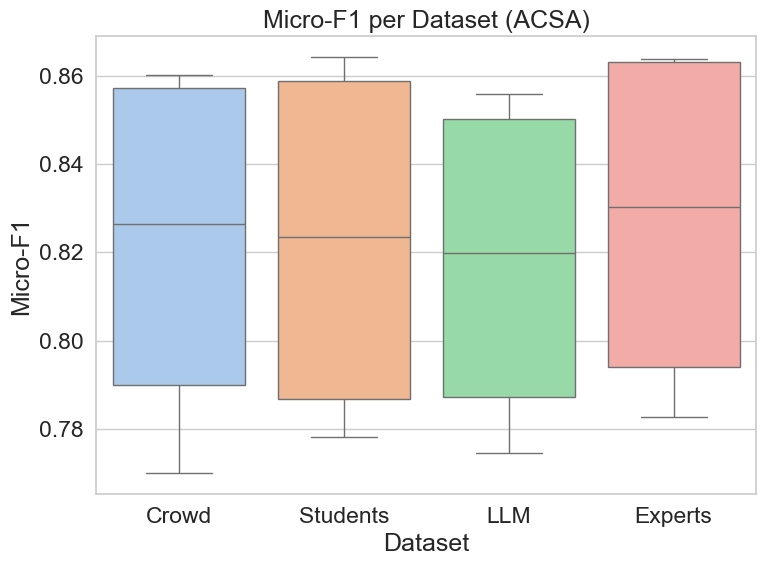

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Excel
task = "acsa"
file_path = f"../../12_results/summary/{task}.xlsx"
df = pd.read_excel(file_path)

metric = "Micro-F1"
dataset_order = ["Crowd", "Students", "LLM", "Experts"]

# Step 1: Average over seeds
avg_seed_df = df.groupby(["Dataset", "Model"], as_index=False)[metric].mean()

# Step 2 & 3: Prepare for boxplot: combine all models per dataset
# In other words, each box contains values from all models (1 value per model)
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.boxplot(
    data=avg_seed_df,
    x="Dataset",
    y=metric,
    order=dataset_order,
    showfliers=False,
    palette="pastel"
)


plt.title(f"{metric} per Dataset ({task.upper()})")
plt.ylabel(metric)
plt.xlabel("Dataset")
plt.tight_layout()
plt.savefig(f"micro_f1_average_over_models_across_datasets_{task}.pdf", bbox_inches="tight")
plt.show()
